In [5]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv('./data/cleaned/consumption_temp_w_features.csv')


In [6]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np

### Preprocessing data for linear regression

df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].apply(lambda x: x.timestamp())

# Fill null values since linear regression can't deal
df['consumption_lag_last_week'].fillna(df['consumption'], inplace=True)
df['consumption_lag_5_days'].fillna(df['consumption'], inplace=True)
df['consumption_ma_week'].fillna(df['consumption'], inplace=True)
df['consumption_max_week'].fillna(df['consumption'], inplace=True)
df['consumption_min_week'].fillna(df['consumption'], inplace=True)
df['temperature_diff_prev_day'].fillna(df['temperature'], inplace=True)

# one-hot encode location
df_one_hot = pd.get_dummies(df['location'])

# join the one-hot encoded df with the original dataframe
df = pd.concat([df, df_one_hot], axis=1)

# drop location which is now one-hot encoded, also date idk if its a useful
# feature
df.drop(['location', 'date'], axis=1, inplace=True)

df.to_csv('./data/preprocessed/lin_reg_preproccessed.csv', index=False)


In [16]:
# Original columns from ANEO timeset excluding consumption and location (one-
# hot encoded)
features = ['time','temperature']

# Added columns
# Can play around a bit with these:)
features += ['is_holiday','weekday','hour_of_day','consumption_lag_last_week','consumption_lag_5_days','season','temperature_diff_prev_day','consumption_ma_week','consumption_max_week','consumption_min_week','consumption_ewm_alpha_0.5','bergen','helsingfors','oslo','stavanger','tromsø','trondheim']

# Separate features and target

#X = df[features].values
#y = df['consumption'].values

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

X_train = df_train[features].values
y_train = df_train['consumption'].values

# Separate features and target for the test set
X_test = df_test[features].values
y_test = df_test['consumption'].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
df_predictions = pd.DataFrame(y_pred, columns=['Predicted'])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

### Compared to predicting mean every time as a baseline:

# Calculate the mean of y_train
mean_consumption = np.mean(y_train)

# Create a list with the mean value repeated for the length of y_test
mean_predictions = [mean_consumption] * len(y_test)

# Create the baseline list
baseline_last_week = df_test['consumption_lag_last_week'].tolist()


# Calculate the MSE
print("Mean predictions")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, mean_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, mean_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, mean_predictions)))
#Mean Absolute Error: 2.362983564642671
#Mean Squared Error: 9.643884140712572
#Root Mean Squared Error: 3.1054603750028065



print("Use value of last week")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, baseline_last_week))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, baseline_last_week))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, baseline_last_week)))
#Mean Absolute Error: 3.1413100479045064
#Mean Squared Error: 19.441355868936153
#Root Mean Squared Error: 4.409235292988587




# If our model's MSE is lower, its doiong better than predicting the mean every 
# time



# Some scores for different features:

# W/o last 5 days lagged feature but all other features included:
# Mean Absolute Error: 0.0703430708310453
# Mean Squared Error: 0.013756084315480399
# Root Mean Squared Error: 0.11728633473461603

# With both last week and 5 days lagged and all other features:
# Mean Absolute Error: 0.06956879391767189
# Mean Squared Error: 0.013346395589595678
# Root Mean Squared Error: 0.11552660122065254

# Can remove and add features to check performance...


Mean Absolute Error: 0.06862525179914886
Mean Squared Error: 0.012964358279225485
Root Mean Squared Error: 0.11386113594737006
Mean predictions
Mean Absolute Error: 2.362983564642671
Mean Squared Error: 9.643884140712572
Root Mean Squared Error: 3.1054603750028065
Use value of last week
Mean Absolute Error: 3.1413100479045064
Mean Squared Error: 19.441355868936153
Root Mean Squared Error: 4.409235292988587


In [157]:
# Convert X_test back to a DataFrame
X_test_df = pd.DataFrame(X_test, columns=features)

# Add y_test and y_pred to this DataFrame
X_test_df['actual_consumption'] = y_test
X_test_df['predicted_consumption'] = y_pred

# Add y_mean prediction and y_last_week to the DataFrame
X_test_df['predicted_last_week_consumption'] = baseline_last_week
X_test_df['mean_prediction_consumption'] = mean_predictions

# Save the DataFrame as a CSV file
X_test_df.to_csv('./data/result/predictions.csv', index=False)


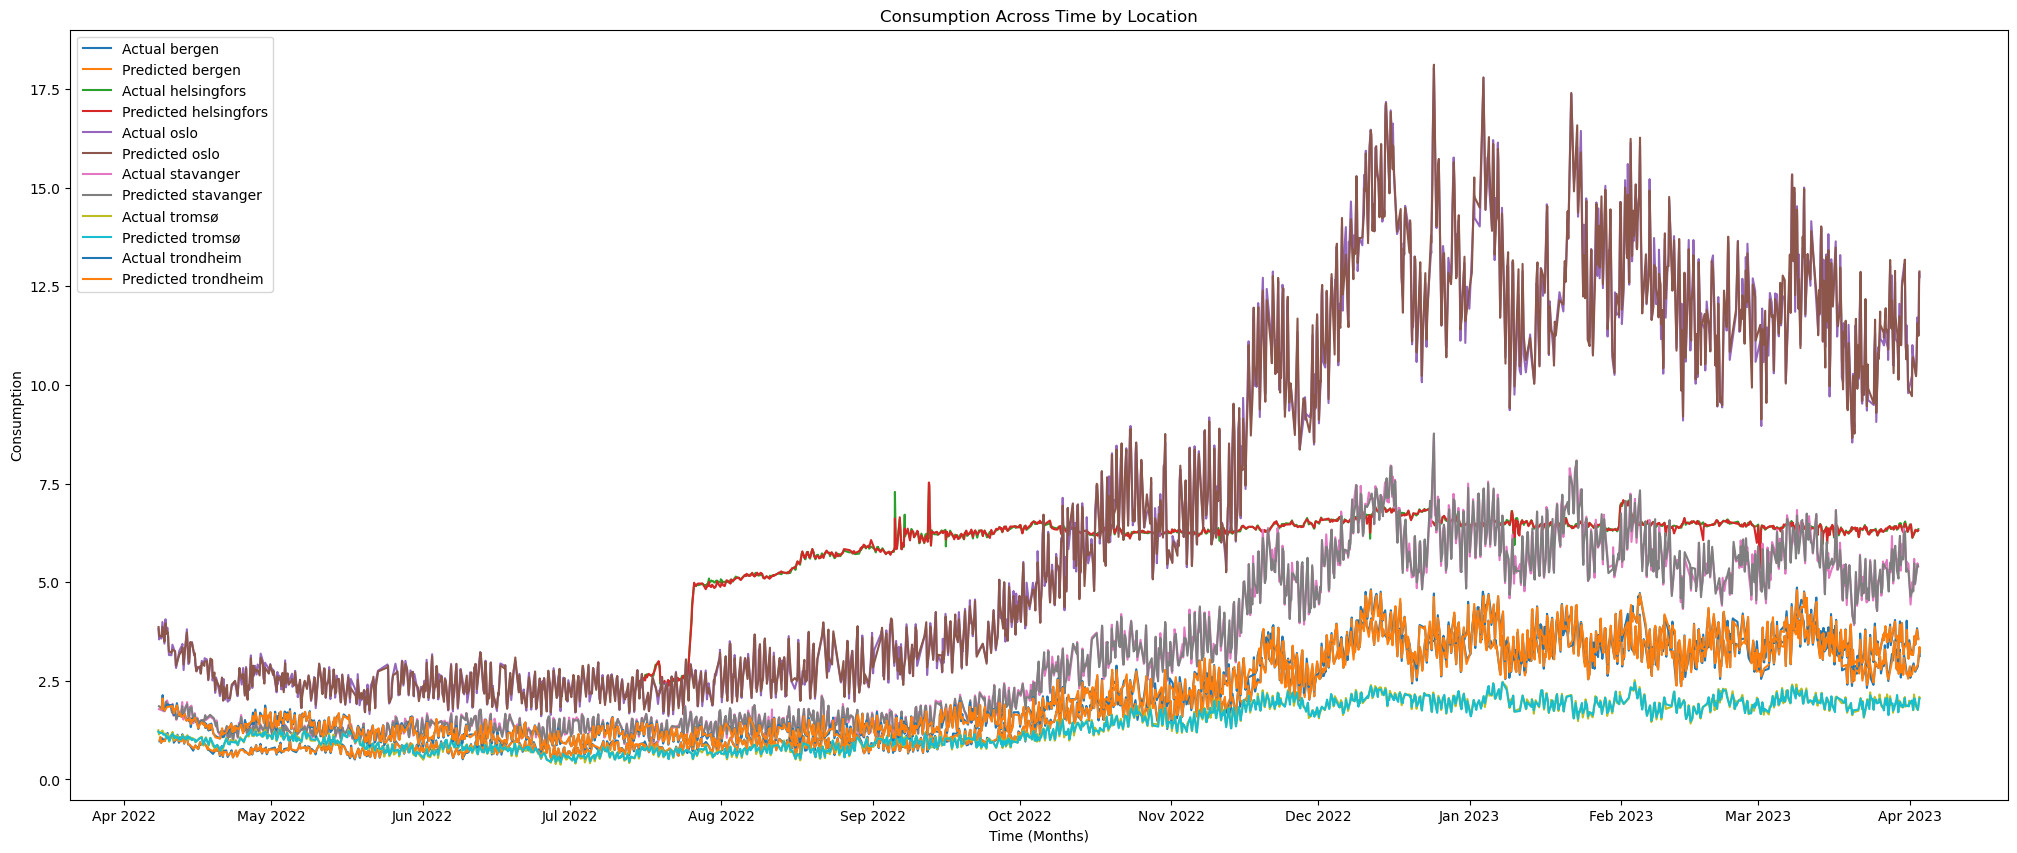

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(25, 10))

# Convert X_test back into a DataFrame
X_test_df = pd.DataFrame(X_test, columns=features)

# Add 'y_test' and 'y_pred' to this DataFrame
X_test_df['Actual Consumption'] = y_test
X_test_df['Predicted Consumption'] = y_pred
X_test_df["Predicted Last Week"] = baseline_last_week
X_test_df["Predicted Mean Consumption"] = mean_predictions


# Convert 'time' column back to datetime format
X_test_df['time'] = X_test_df['time'].apply(lambda x: datetime.fromtimestamp(x))

X_test_df.sort_values(by='time', inplace=True)

# List of locations
locations = ['bergen', 'helsingfors', 'oslo', 'stavanger', 'tromsø', 'trondheim']

# Loop through each location
for location in locations:
    # Filter data for the current location
    location_data = X_test_df[X_test_df[location] == 1]
    
    # Plot actual values for the current location
    ax.plot(location_data['time'], location_data['Actual Consumption'], label=f'Actual {location}')
    
    # Plot predicted values for the current location
    ax.plot(location_data['time'], location_data['Predicted Consumption'], label=f'Predicted {location}')
    

# Set the title and labels
ax.set_title('Consumption Across Time by Location')
ax.set_xlabel('Time (Months)')
ax.set_ylabel('Consumption')

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Display the legend
ax.legend()

# Show the plot
plt.show()


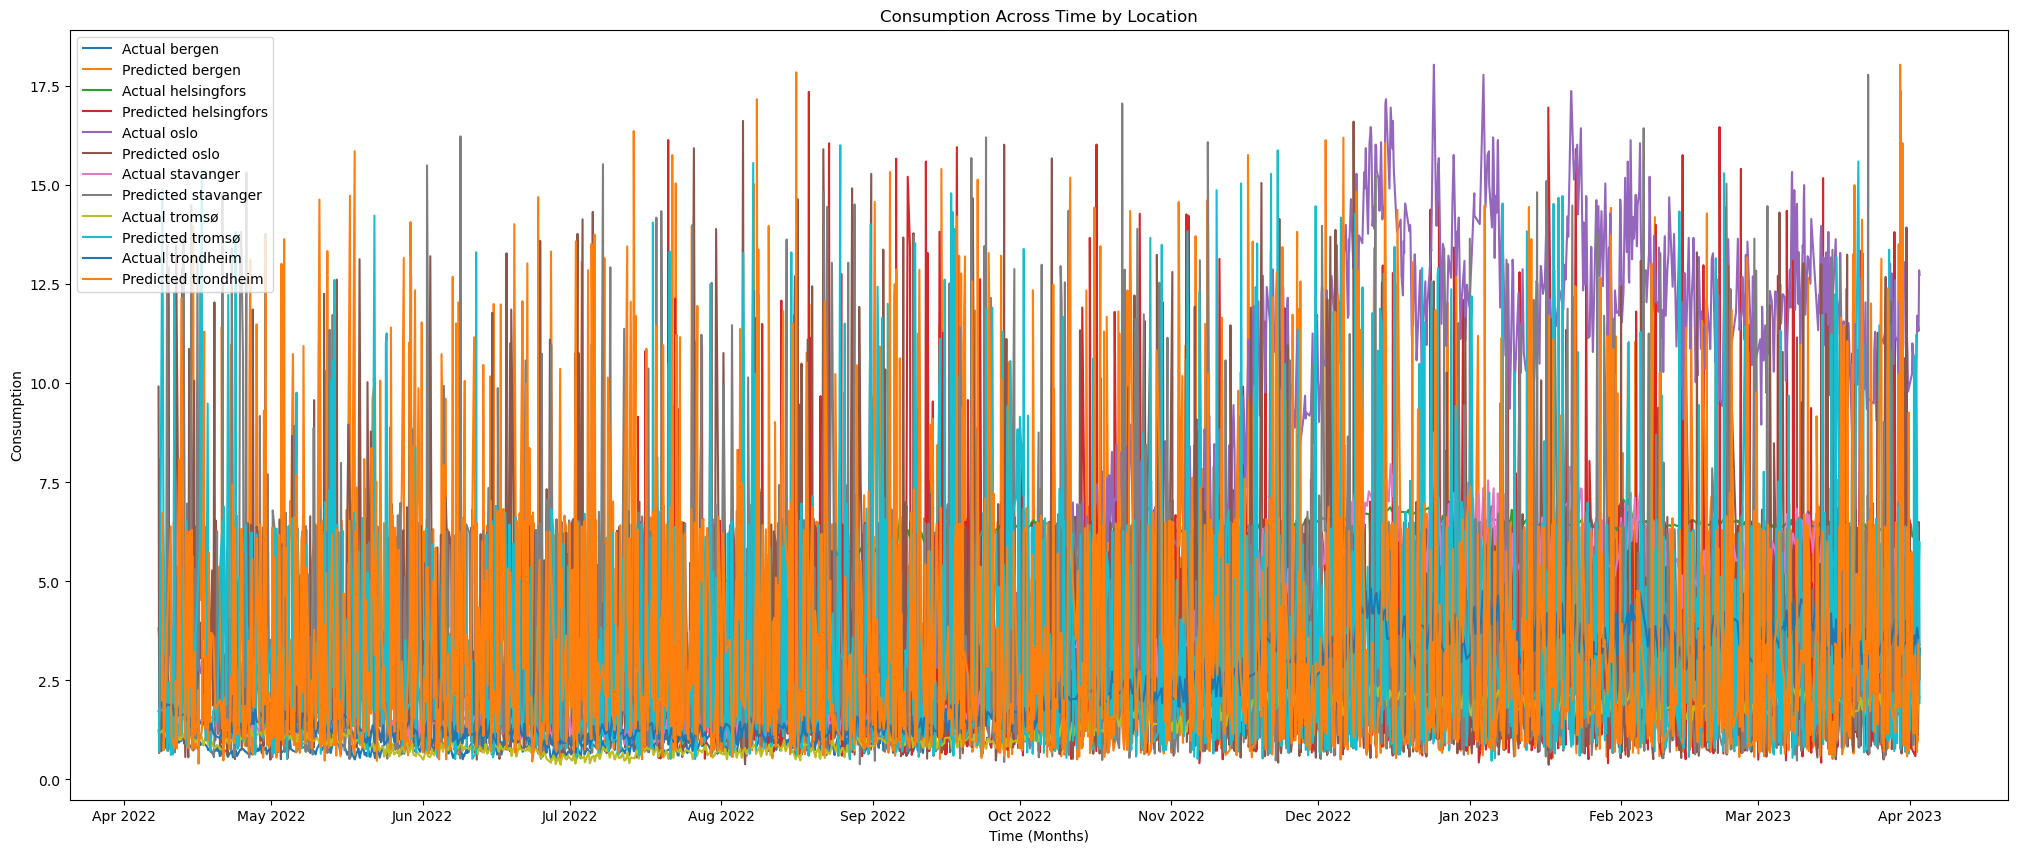

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(25, 10))

# Convert X_test back into a DataFrame
X_test_df = pd.DataFrame(X_test, columns=features)

# Add 'y_test' and 'y_pred' to this DataFrame
X_test_df['Actual Consumption'] = y_test
X_test_df["Predicted Last Week"] = baseline_last_week


# Convert 'time' column back to datetime format
X_test_df['time'] = X_test_df['time'].apply(lambda x: datetime.fromtimestamp(x))

X_test_df.sort_values(by='time', inplace=True)

# List of locations
locations = ['bergen', 'helsingfors', 'oslo', 'stavanger', 'tromsø', 'trondheim']

# Loop through each location
for location in locations:
    # Filter data for the current location
    location_data = X_test_df[X_test_df[location] == 1]
    
    # Plot actual values for the current location
    ax.plot(location_data['time'], location_data['Actual Consumption'], label=f'Actual {location}')

    # Plot predicted mean values for the current location
    ax.plot(location_data['time'], location_data["Predicted Last Week"], label=f'Predicted {location}')        


    

# Set the title and labels
ax.set_title('Consumption Across Time by Location')
ax.set_xlabel('Time (Months)')
ax.set_ylabel('Consumption')

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Display the legend
ax.legend()

# Show the plot
plt.show()

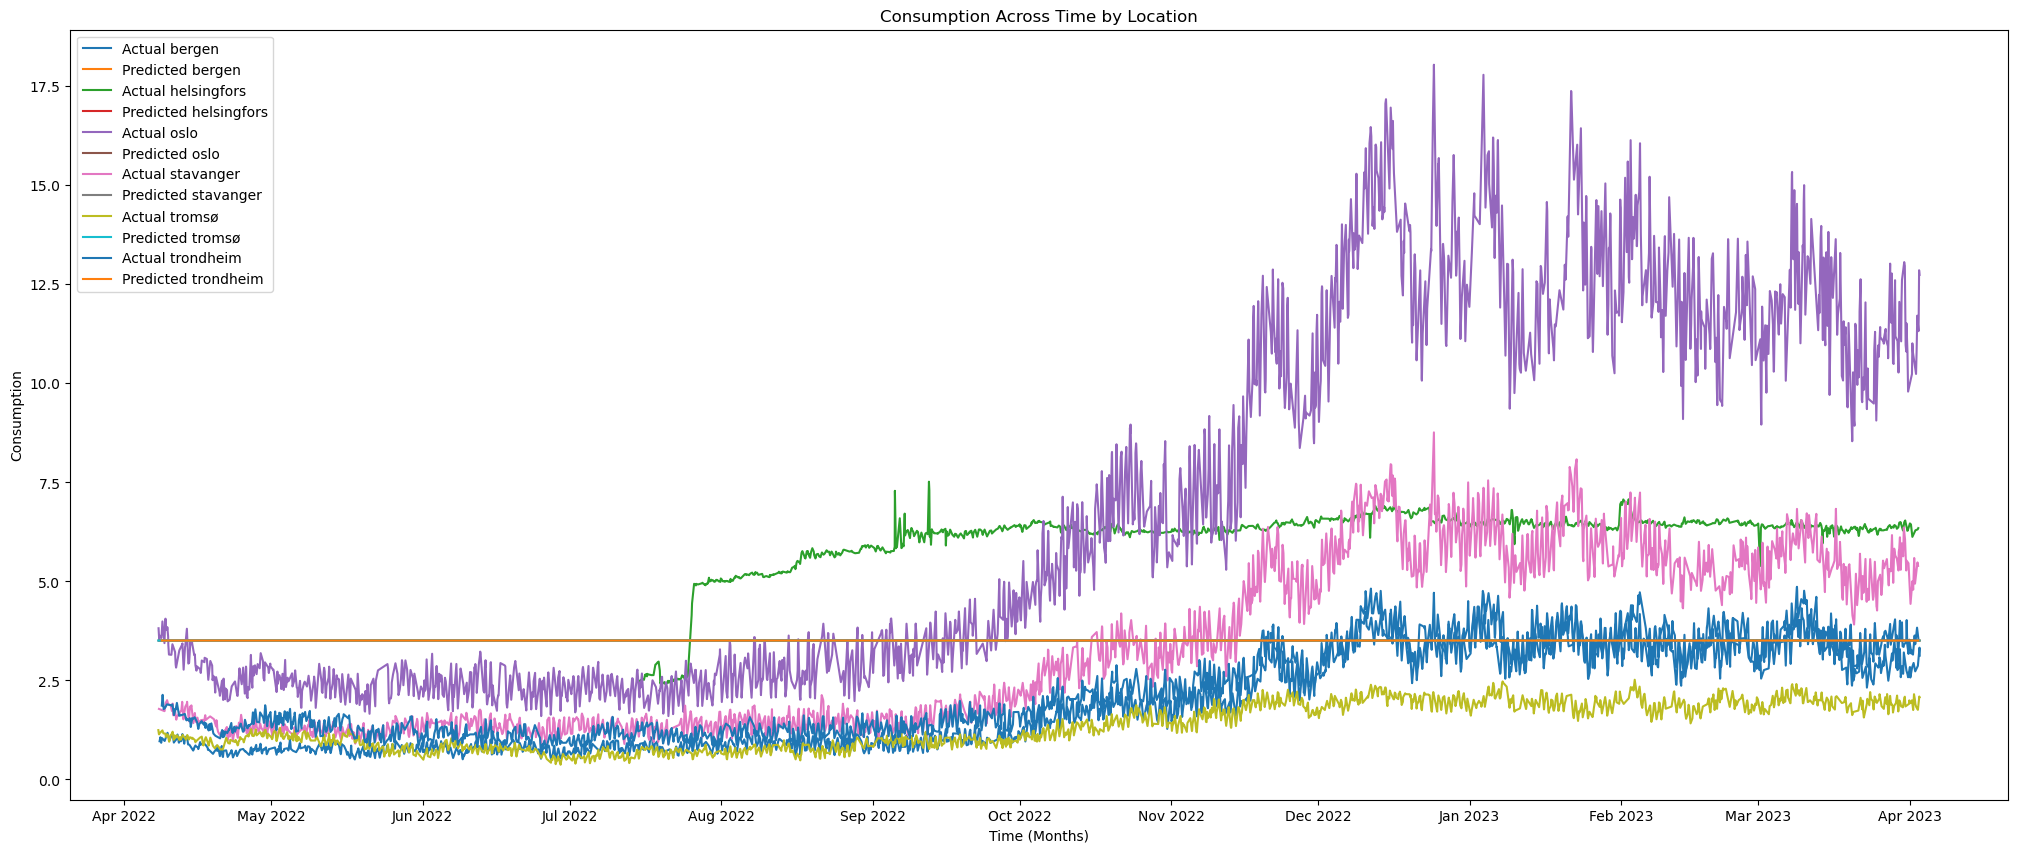

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(25, 10))

# Convert X_test back into a DataFrame
X_test_df = pd.DataFrame(X_test, columns=features)

# Add 'y_test' and 'y_pred' to this DataFrame
X_test_df['Actual Consumption'] = y_test
X_test_df["Predicted Mean Consumption"] = mean_predictions


# Convert 'time' column back to datetime format
X_test_df['time'] = X_test_df['time'].apply(lambda x: datetime.fromtimestamp(x))

X_test_df.sort_values(by='time', inplace=True)

# List of locations
locations = ['bergen', 'helsingfors', 'oslo', 'stavanger', 'tromsø', 'trondheim']

# Loop through each location
for location in locations:
    # Filter data for the current location
    location_data = X_test_df[X_test_df[location] == 1]
    
    # Plot actual values for the current location
    ax.plot(location_data['time'], location_data['Actual Consumption'], label=f'Actual {location}')
    
    # Plot last week value for current location
    ax.plot(location_data['time'], location_data['Predicted Mean Consumption'], label=f'Predicted {location}')

    

# Set the title and labels
ax.set_title('Consumption Across Time by Location')
ax.set_xlabel('Time (Months)')
ax.set_ylabel('Consumption')

# Format x-axis to show months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Display the legend
ax.legend()

# Show the plot
plt.show()